#### 1. Import and clean data

In [1]:
from io import open
import glob
import os

files_path = 'data/names/*.txt'
def find_files(path): return(glob.glob(path))

print(find_files(files_path))


['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

#Turn unicode strings to ASCII
def unicode_to_ascii(s):
    return ''.join(
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn' and char in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
category_words = {}
all_categories = []

# read a file and split it into lines
def read_words(file_name):
    words = open(file_name, encoding='utf-8').read().strip().split('\n')
    return[unicode_to_ascii(word) for word in words]

for file_name in find_files(files_path):
    category = os.path.splitext(os.path.basename(file_name))[0]
    all_categories.append(category)
    words = read_words(file_name)
    category_words[category] = words

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


#### 2. Convert words to tensors

In [4]:
import torch, random

def letter_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_index(letter)] = 1
    return tensor

def input_tensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for index, letter in enumerate(word):
        tensor[index][0][letter_index(letter)] = 1
    return tensor

def category_tensor(category):
    index = all_categories.index(category)
    tensor =  torch.zeros(1, n_categories)
    tensor[0][index] = 1
    return tensor

def target_tensor(word):
    letter_indexes = [
        all_letters.find(word[index])
        for index in range(1, len(word))
        ]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

def random_choice(list_item):
    return list_item[random.randint(0, len(list_item) - 1)]

def random_training_pair():
    category = random_choice(all_categories)
    word = random_choice(category_words[category])
    return category, word

def random_training_example():
    _category, _word = random_training_pair()
    _category_tensor = category_tensor(_category)
    _input_tensor = input_tensor(_word)
    _target_tensor = target_tensor(_word)
    return _category_tensor, _input_tensor, _target_tensor
    
print(letter_index('A'))
print(letter_to_tensor('a'))
print(input_tensor('abc').size())
print(category_tensor('Irish'))
print(target_tensor('Cheng'))
for i in range(10):
    category, word  = random_training_pair()
    print('category:', category, '\t|\t word:', word)

26
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])
torch.Size([3, 1, 59])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([ 7,  4, 13,  6, 58])
category: Irish 	|	 word: Dalach
category: Irish 	|	 word: O'Brian
category: Czech 	|	 word: Pellar
category: Polish 	|	 word: Warszawski
category: Chinese 	|	 word: Zhuo
category: German 	|	 word: Katz
category: Scottish 	|	 word: Fraser
category: Czech 	|	 word: Stites
category: Polish 	|	 word: Broz
category: Italian 	|	 word: Zangari


#### 3. RNN Network design
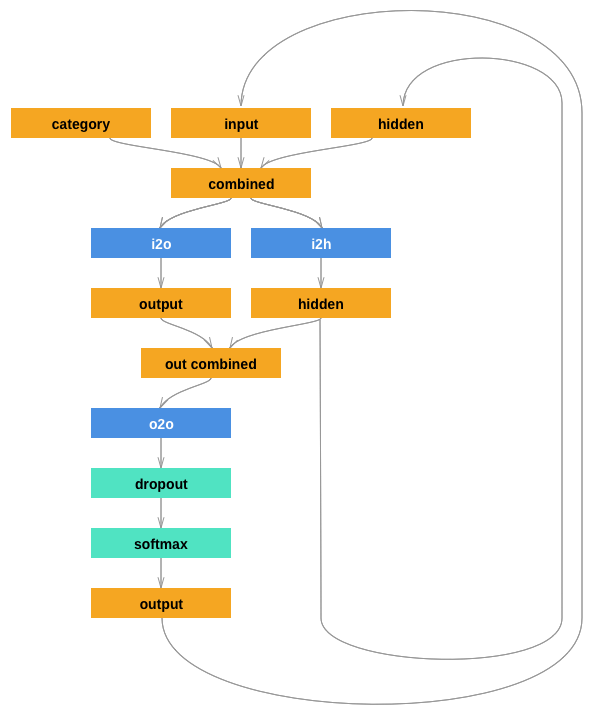

In [5]:
import torch
import torch.nn as nn
from torchinfo import summary


class RNNWordGen(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNWordGen, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    


#### 4. Training

In [6]:
criterion = nn.NLLLoss()
learning_rate = 5e-4

def train(category_tensor, input_tensor, target_tensor):
    target_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    losses = torch.Tensor([0])

    for i in range(input_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_tensor[i], hidden)
        loss = criterion(output, target_tensor[i])
        losses += loss

    losses.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, losses.item() / input_tensor.size(0)

In [10]:
import time
import math

n_hidden = 128
rnn = RNNWordGen(n_letters, n_hidden, n_letters)
print(summary(rnn))

n_iters = 100000
print_every = 5*n_iters//100
plot_every = print_every//5

total_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    sec = now - since
    min = math.floor(sec/60)
    sec -= min * 60
    return '%dm %ds' % (min, sec)

start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*random_training_example())
    total_loss += loss
    
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        print('%d\t %d%% (%s) %.4f' % (iter, iter / n_iters * 100, time_since(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

model_path = 'models/name_generator.pt'
torch.save(rnn.state_dict(), model_path)

Layer (type:depth-idx)                   Param #
RNNWordGen                               --
├─Linear: 1-1                            26,368
├─Linear: 1-2                            12,154
├─Linear: 1-3                            11,092
├─Dropout: 1-4                           --
├─LogSoftmax: 1-5                        --
Total params: 49,614
Trainable params: 49,614
Non-trainable params: 0
5000 5% (0m 27s) 3.4419
10000 10% (0m 53s) 2.7161
15000 15% (1m 20s) 3.2489
20000 20% (1m 58s) 1.9959


In [ ]:
rnn = rnn(n_letters, 128, n_letters)
rnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

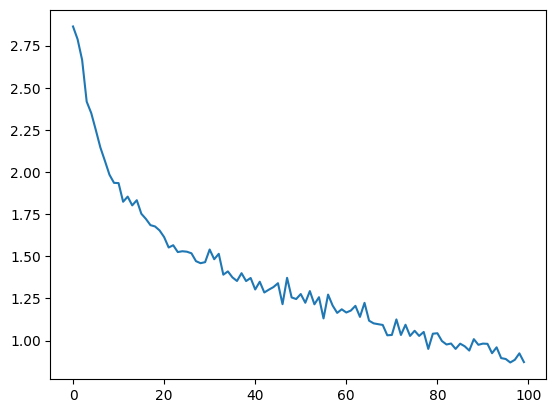

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#### 5. Evaluation

C:\Users\AttahiruJibril\AppData\Local\Temp\ipykernel_4156\3897230354.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation = 90)
C:\Users\AttahiruJibril\AppData\Local\Temp\ipykernel_4156\3897230354.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


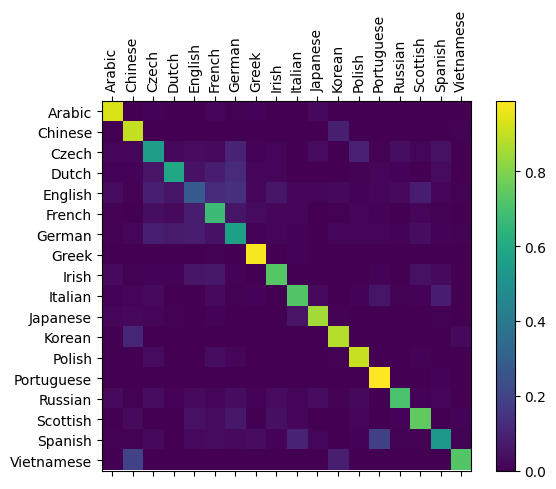

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# return an output give a word
def evaluate(word_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)
    
    return output

#record correct guesses from examples
for i in range(n_confusion):
    _category, word, category_tensor, word_tensor = random_training_pair()
    output = evaluate(word_tensor)
    guess, guess_idx = category_from_output(output)
    category_idx = all_categories.index(_category)
    confusion[category_idx][guess_idx] += 1
    
# normalize confusion
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()

#plot 
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [ ]:
def predict(input_word, n_predictions=3):
    print('\n> %s' % input_word)
    with torch.no_grad():
        output = evaluate(input_tensor(input_word))
        top_pred, top_pred_idx = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            pred = top_pred[0][i].item()
            category_idx = top_pred_idx[0][i].item()
            print('(%.2f) %s' % (pred, all_categories[category_idx]))
            predictions.append([pred, all_categories[category_idx]])


predict('Jackson')
predict('Dovesky')
predict('Derrick')


> Jackson
(-0.82) Scottish
(-0.88) English
(-3.02) Russian

> Dovesky
(-0.75) Russian
(-0.90) Czech
(-3.13) Polish

> Derrick
(-1.17) Czech
(-1.29) English
(-1.71) German
